# This notebook contains training step and analysis using nmae result...

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, GenericUnivariateSelect
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, KFold
from scipy import stats

import xgboost as xgb

In [2]:
# Normalized Mean Absolute Error
def nmae(y_pred, y_test):
    mae = mean_absolute_error(y_test, y_pred)
    # mape = np.abs(y_test_idx - y_pred_idx) / y_test_idx
    mean_true = np.mean(np.abs(y_test))
    return (mae / mean_true)

def normalized_mean_absolute_error(y_true, y_pred):
    """
    Calculates the Normalized Mean Absolute Error (NMAE).

    Args:
        y_true (array-like): Ground truth (correct) target values.
        y_pred (array-like): Estimated target values.

    Returns:
        float: The Normalized Mean Absolute Error.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length.")

    mae = np.mean(np.abs(y_true - y_pred))

    # Calculate the range of actual values
    y_range = np.max(y_true) - np.min(y_true)

    # Avoid division by zero if the range is zero
    if y_range == 0:
        return 0.0 if mae == 0 else np.inf
    else:
        nmae = mae / y_range
        return nmae

def print_scores(scores, name="NMAE"):
    """
    Prints cross-validation scores returned by cross_val_score.
    Since error scorers in sklearn are usually negative (greater_is_better=False),
    this function converts them to positive percentages.
    """
    scores_pct = -scores * 100  # convert to positive percentage

    print(f"{name} per fold:")
    for i, s in enumerate(scores_pct):
        print(f"  Fold {i+1}: {s:.2f}%")

    print(f"\nMean {name}: {np.mean(scores_pct):.2f}%")

def replace_outliers_zscore(x_dataset, y_dataset, target_col):
    y = y_dataset[["timestamp", target_col]].copy()
    df = pd.merge(x_dataset, y, on="timestamp", how="inner")

    # Calculate Z-scores
    z_scores = stats.zscore(df[target_col])
    
    # Define a threshold
    threshold = 2


    # 3. Mark outliers as NaN (Not a Number)
    # This removes the "bad" data so the interpolation doesn't use it
    df['target_cleaned'] = df[target_col].copy()
    df.loc[z_scores > threshold, 'target_cleaned'] = np.nan
    
    # 4. Replace the NaNs using Linear Interpolation
    df['target_cleaned'] = df['target_cleaned'].interpolate(method='linear')
    
    # Optional: Fill any NaNs at the very beginning or end that interpolation can't reach
    df['target_cleaned'] = df['target_cleaned'].ffill().bfill()
    
    y = df[[target_col, 'target_cleaned']].copy()
    X = df.drop(columns=[target_col, 'target_cleaned'])
    
    return X, y

In [2]:
# Load write dataset t100
x_t100 = pd.read_csv('datasets/exp90c_11h_v3/t100/prometheus_metrics_wide.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(x_t100.shape)
x_t100 = x_t100.iloc[3600:]
print(x_t100.shape)
x_t100.head(5)

(40203, 433)
(36603, 433)


,timestamp,container_blkio_device_usage_total_0,container_blkio_device_usage_total_1,container_blkio_device_usage_total_2,container_blkio_device_usage_total_3,container_cpu_load_average_10s_0,container_cpu_load_d_average_10s_0,container_cpu_system_seconds_total_0,container_cpu_usage_seconds_total_0,container_cpu_user_seconds_total_0,...,node_network_up_6,node_network_up_7,inst_node_cpu_usage_0,user_cpu_usage_0,system_cpu_usage_0,memory_usage_per_container_0,network_receive_bytes_per_container_0,network_receive_bytes_per_container_1,network_transmit_bytes_per_container_0,network_transmit_bytes_per_container_1
3600,1765457587,957624320,280073580544,957624320,225810305024,0,0,131993.593639,565713.006870,433719.413230,...,1,1,109.876073,70.455654,40.747280,42.453067,644120.193677,597209.911706,1.222416e+06,1.216188e+06
3601,1765457588,957624320,280073592832,957624320,225810305024,0,0,131994.305913,565715.012686,433720.706773,...,1,1,111.002546,71.066009,39.418625,42.460219,649871.150972,612380.568012,1.236922e+06,1.205575e+06
3602,1765457589,957624320,280073592832,957624320,225810305024,0,0,131994.305913,565715.012686,433720.706773,...,1,1,111.002546,71.066009,39.418625,42.460219,649871.150972,612380.568012,1.236922e+06,1.205575e+06
3603,1765457590,957624320,280073592832,957624320,225810305024,0,0,131994.788680,565716.297189,433721.508509,...,1,1,108.764014,70.123126,39.994679,42.457835,659532.128514,621317.269076,1.250915e+06,1.210313e+06
3604,1765457591,957624320,280074452992,957624320,225811165184,0,0,131995.343469,565718.432836,433723.089366,...,1,1,148.515090,83.057750,39.535246,42.459297,662910.302756,620738.364211,1.254367e+06,1.216718e+06


In [3]:
# Load y t100 write
y_t100_w = pd.read_csv('datasets/exp90c_11h_v3/t100/20251211_115307653_w.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t100_w.shape)
y_t100_w = y_t100_w.iloc[3600:]
print(y_t100_w.shape)
y_t100_w.head(5)

(40203, 45)
(36603, 45)


,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
3600,1765457587,180008,0,0,0,2,3,47.985586,49.997836,49.997101,...,1,4,2.026667,0.243900,2.0,2.0,2.0,3.00,3.000000,4
3601,1765457588,180058,0,0,0,2,3,47.986128,49.997836,49.997101,...,1,4,2.033333,0.256466,2.0,2.0,2.0,3.00,3.000000,4
3602,1765457589,180108,0,0,0,2,3,47.986668,49.997836,49.997101,...,1,3,2.026667,0.229779,2.0,2.0,2.0,3.00,3.000000,3
3603,1765457590,180158,0,0,0,2,3,47.987205,49.997836,49.997101,...,1,4,2.060000,0.300056,2.0,2.0,3.0,3.00,3.663333,4
3604,1765457591,180208,0,0,0,2,3,47.987741,49.998009,49.997149,...,2,4,2.106667,0.368431,2.0,2.0,3.0,3.66,4.000000,4


In [4]:
# Load y t100 read
y_t100_r = pd.read_csv('datasets/exp90c_11h_v3/t100/20251211_115307653_r.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t100_r.shape)
y_t100_r = y_t100_r.iloc[3600:]
print(y_t100_r.shape)
y_t100_r.head(5)

(40203, 45)
(36603, 45)


,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
3600,1765457587,179996,0,0,0,4,1,48.762267,49.999209,49.998197,...,3,17,3.786667,1.748718,3.0,4.0,6.00,10.00,14.000000,17
3601,1765457588,180046,0,0,0,4,4,48.762558,49.999209,49.998197,...,3,17,3.840000,1.795870,3.0,4.0,6.00,10.00,14.000000,17
3602,1765457589,180096,0,0,0,4,4,48.762946,49.999209,49.998197,...,3,45,4.056667,3.181277,4.0,4.0,7.00,11.98,14.663333,45
3603,1765457590,180146,0,0,0,4,4,48.763280,49.999209,49.998197,...,3,45,4.066667,3.153098,4.0,4.0,6.00,11.98,14.663333,45
3604,1765457591,180196,0,0,0,4,4,48.763618,49.999272,49.998227,...,3,45,4.026667,3.076389,4.0,4.0,5.65,10.00,14.663333,45


In [5]:
# Load write dataset t300
x_t300 = pd.read_csv('datasets/exp90c_11h_v3/t300/prometheus_metrics_wide.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(x_t300.shape)
x_t300 = x_t300.iloc[3600:]
print(x_t300.shape)
x_t300.head(5)

(40203, 433)
(36603, 433)


,timestamp,container_blkio_device_usage_total_0,container_blkio_device_usage_total_1,container_blkio_device_usage_total_2,container_blkio_device_usage_total_3,container_cpu_load_average_10s_0,container_cpu_load_d_average_10s_0,container_cpu_system_seconds_total_0,container_cpu_usage_seconds_total_0,container_cpu_user_seconds_total_0,...,node_network_up_6,node_network_up_7,inst_node_cpu_usage_0,user_cpu_usage_0,system_cpu_usage_0,memory_usage_per_container_0,network_receive_bytes_per_container_0,network_receive_bytes_per_container_1,network_transmit_bytes_per_container_0,network_transmit_bytes_per_container_1
3600,1765541257,516096,301706129408,516096,254511370240,0,0,34164.757504,288790.546185,254625.788680,...,1,1,56.673510,42.055651,14.048099,40.365887,1.541635e+06,406065.881093,785401.178361,1.341288e+06
3601,1765541258,516096,301706129408,516096,254511370240,0,0,34164.757504,288790.546185,254625.788680,...,1,1,56.673510,43.289653,13.383857,40.365887,1.539640e+06,405741.603467,792390.574215,1.340699e+06
3602,1765541259,516096,301706657792,516096,254511370240,0,0,34165.027843,288792.930616,254627.902773,...,1,1,136.409096,81.057874,14.396355,40.371227,1.556834e+06,407666.666667,788142.459655,1.347146e+06
3603,1765541260,516096,301706657792,516096,254511370240,0,0,34165.173952,288794.578534,254629.404581,...,1,1,153.437430,128.132566,14.757193,40.379333,1.580540e+06,406377.746279,778009.567682,1.351461e+06
3604,1765541261,516096,301708967936,516096,254513680384,0,0,34165.412584,288795.528695,254630.116110,...,1,1,58.615731,97.398830,14.744092,40.388997,1.592456e+06,406114.112086,774219.896466,1.348744e+06


In [6]:
# Load y t300 write
y_t300_w = pd.read_csv('datasets/exp90c_11h_v3/t300/20251212_110737208_w.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t300_w.shape)
y_t300_w = y_t300_w.iloc[3600:]
print(y_t300_w.shape)
y_t300_w.head(5)

(40203, 45)
(36603, 45)


,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
3600,1765541257,180008,0,0,0,3,3,47.984890,49.999983,49.998706,...,2,4,2.113333,0.327893,2.0,2.0,3.0,3.0,3.0,4
3601,1765541258,180058,0,0,0,3,3,47.985418,49.999983,49.998706,...,2,3,2.116667,0.321559,2.0,2.0,3.0,3.0,3.0,3
3602,1765541259,180108,0,0,0,3,3,47.985961,49.999983,49.998706,...,2,4,2.173333,0.387888,2.0,2.0,3.0,3.0,3.0,4
3603,1765541260,180158,0,0,0,3,3,47.986496,49.999983,49.998706,...,2,4,2.190000,0.401377,2.0,2.0,3.0,3.0,3.0,4
3604,1765541261,180208,0,0,0,3,3,47.987039,49.999984,49.998728,...,2,4,2.196667,0.406456,2.0,2.0,3.0,3.0,3.0,4


In [7]:
# Load y t300 read
y_t300_r = pd.read_csv('datasets/exp90c_11h_v3/t300/20251212_110737208_r.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t300_r.shape)
y_t300_r = y_t300_r.iloc[3600:]
print(y_t300_r.shape)
y_t300_r.head(5)

(40203, 45)
(36603, 45)


,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
3600,1765541257,179996,0,0,0,9,4,48.764276,49.999983,49.998711,...,6,9,6.170000,0.426269,6.0,6.0,7.00,7.00,8.000000,9
3601,1765541258,180046,0,0,0,9,4,48.764600,49.999983,49.998711,...,6,9,6.223333,0.517379,6.0,6.0,7.00,8.00,8.663333,9
3602,1765541259,180096,0,0,0,9,4,48.764877,49.999983,49.998711,...,6,112,7.406667,9.224873,6.0,7.0,7.00,12.30,68.573333,112
3603,1765541260,180146,0,0,0,9,4,48.765267,49.999983,49.998711,...,6,122,8.766667,13.756563,6.0,7.0,8.65,72.22,95.960000,122
3604,1765541261,180196,0,0,0,9,4,48.765634,49.999984,49.998732,...,6,122,8.783333,13.755256,6.0,7.0,9.00,72.22,95.960000,122


In [8]:
# Load write dataset t500
x_t500 = pd.read_csv('datasets/exp90c_11h_v3/t500/prometheus_metrics_wide.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(x_t500.shape)
x_t500 = x_t500.iloc[3600:]
print(x_t500.shape)
x_t500.head(5)

(40203, 433)
(36603, 433)


,timestamp,container_blkio_device_usage_total_0,container_blkio_device_usage_total_1,container_blkio_device_usage_total_2,container_blkio_device_usage_total_3,container_cpu_load_average_10s_0,container_cpu_load_d_average_10s_0,container_cpu_system_seconds_total_0,container_cpu_usage_seconds_total_0,container_cpu_user_seconds_total_0,...,node_network_up_6,node_network_up_7,inst_node_cpu_usage_0,user_cpu_usage_0,system_cpu_usage_0,memory_usage_per_container_0,network_receive_bytes_per_container_0,network_receive_bytes_per_container_1,network_transmit_bytes_per_container_0,network_transmit_bytes_per_container_1
3600,1765928596,479440896,93772931072,479440896,81549856768,0,0,17105.641997,113817.243797,96711.601799,...,1.0,1.0,145.052231,118.003704,27.221289,70.678361,1.724608e+06,2.471341e+06,1.611597e+06,5.076593e+06
3601,1765928597,479440896,93775093760,479440896,81552019456,0,0,17105.992557,113819.095086,96713.102528,...,1.0,1.0,149.901943,119.707875,27.569205,70.687962,1.744561e+06,2.544521e+06,1.657680e+06,5.236508e+06
3602,1765928598,479440896,93775093760,479440896,81552019456,0,0,17106.295609,113820.542110,96714.246500,...,1.0,1.0,141.865098,117.632220,28.157732,70.696576,1.717351e+06,2.569721e+06,1.650878e+06,5.180150e+06
3603,1765928599,479440896,93775093760,479440896,81552019456,0,0,17106.615671,113822.253547,96715.637875,...,1.0,1.0,153.629892,119.800416,28.900980,70.706558,1.739516e+06,2.584913e+06,1.679461e+06,5.254451e+06
3604,1765928600,479440896,93775093760,479440896,81552019456,0,0,17107.014975,113824.497046,96717.482071,...,1.0,1.0,154.192371,122.026832,28.487545,70.718765,1.768154e+06,2.638097e+06,1.697090e+06,5.287780e+06


In [9]:
# Load y t500 write
y_t500_w = pd.read_csv('datasets/exp90c_11h_v3/t500/20251216_224316792_w.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t500_w.shape)
y_t500_w = y_t500_w.iloc[3600:]
print(y_t500_w.shape)
y_t500_w.head(5)

(40203, 45)
(36603, 45)


,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
3600,1765928596,180008,0,0,0,19,1,47.991748,49.997836,49.997102,...,2,15,3.026667,0.805056,3.0,3.0,4.0,4.0,5.0,15
3601,1765928597,180058,0,0,0,19,1,47.992278,49.997836,49.997102,...,2,15,3.023333,0.827691,3.0,3.0,4.0,4.0,5.0,15
3602,1765928598,180108,0,0,0,19,1,47.992821,49.997836,49.997102,...,2,15,3.043333,0.830917,3.0,3.0,4.0,4.0,5.0,15
3603,1765928599,180158,0,0,0,19,1,47.993356,49.997836,49.997102,...,2,15,3.036667,0.827206,3.0,3.0,4.0,4.0,5.0,15
3604,1765928600,180208,0,0,0,19,1,47.993893,49.997836,49.997102,...,2,7,3.000000,0.469825,3.0,3.0,4.0,4.0,5.0,7


In [10]:
# Load y t500 read
y_t500_r = pd.read_csv('datasets/exp90c_11h_v3/t500/20251216_224316792_r.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t500_r.shape)
y_t500_r = y_t500_r.iloc[3600:]
print(y_t500_r.shape)
y_t500_r.head(5)

(40203, 45)
(36603, 45)


,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
3600,1765928596,179996,0,0,0,36,1,48.768630,49.997836,49.997101,...,8,120,10.443333,9.986619,9.0,9.0,11.00,19.62,75.613333,120
3601,1765928597,180046,0,0,0,36,3,48.768969,49.997836,49.997101,...,8,120,10.516667,10.027874,9.0,9.0,11.00,25.30,75.613333,120
3602,1765928598,180096,0,0,0,36,3,48.769315,49.997836,49.997101,...,8,120,10.550000,10.030430,9.0,9.0,11.65,25.30,75.613333,120
3603,1765928599,180146,0,0,0,36,3,48.769641,49.997836,49.997101,...,8,120,10.550000,10.028096,9.0,9.0,11.00,25.30,75.613333,120
3604,1765928600,180196,0,0,0,36,3,48.769983,49.997836,49.997101,...,8,27,9.280000,1.267658,9.0,9.0,10.00,12.00,12.663333,27


In [12]:
# check if X datasets as equals:
print(f"T100 and T300 are equal: {x_t100.columns.equals(x_t300.columns)}")
print(f"T100 and T500 are equal: {x_t100.columns.equals(x_t500.columns)}")

T100 and T300 are equal: True
T100 and T500 are equal: True


In [13]:
cols_with_negatives = x_t100.columns[(x_t100 < 0).any()]
print("\nColumns with values less than zero:")
print(cols_with_negatives)

print(f"x_t100 node_network_speed_bytes_0 min: {x_t100['node_network_speed_bytes_0'].min()}")
print(f"x_t100 node_network_speed_bytes_0 max: {x_t100['node_network_speed_bytes_0'].max()}")

print(f"x_t100 node_network_speed_bytes_2 min: {x_t100['node_network_speed_bytes_2'].min()}")
print(f"x_t100 node_network_speed_bytes_2 max: {x_t100['node_network_speed_bytes_2'].max()}")


Columns with values less than zero:
Index(['node_network_speed_bytes_0', 'node_network_speed_bytes_2'], dtype='object')
x_t100 node_network_speed_bytes_0 min: -125000
x_t100 node_network_speed_bytes_0 max: -125000
x_t100 node_network_speed_bytes_2 min: -125000
x_t100 node_network_speed_bytes_2 max: -125000


In [14]:
# Target values
print(f"T100(W) - Min: {np.min(y_t100_w["w_95th_percentile"].to_numpy())} | Max: {np.max(y_t100_w["w_95th_percentile"].to_numpy())} | Mean: {np.mean(y_t100_w["w_95th_percentile"].to_numpy())}")
print(f"T300(W) - Min: {np.min(y_t300_w["w_95th_percentile"].to_numpy())} | Max: {np.max(y_t300_w["w_95th_percentile"].to_numpy())} | Mean: {np.mean(y_t300_w["w_95th_percentile"].to_numpy())}")
print(f"T500(W) - Min: {np.min(y_t500_w["w_95th_percentile"].to_numpy())} | Max: {np.max(y_t500_w["w_95th_percentile"].to_numpy())} | Mean: {np.mean(y_t500_w["w_95th_percentile"].to_numpy())}")

print(f"T100(R) - Min: {np.min(y_t100_r["w_95th_percentile"].to_numpy())} | Max: {np.max(y_t100_r["w_95th_percentile"].to_numpy())} | Mean: {np.mean(y_t100_r["w_95th_percentile"].to_numpy())}")
print(f"T300(R) - Min: {np.min(y_t300_r["w_95th_percentile"].to_numpy())} | Max: {np.max(y_t300_r["w_95th_percentile"].to_numpy())} | Mean: {np.mean(y_t300_r["w_95th_percentile"].to_numpy())}")
print(f"T500(R) - Min: {np.min(y_t500_r["w_95th_percentile"].to_numpy())} | Max: {np.max(y_t500_r["w_95th_percentile"].to_numpy())} | Mean: {np.mean(y_t500_r["w_95th_percentile"].to_numpy())}")

T100(W) - Min: 2.0 | Max: 176.399999999999 | Mean: 3.371679916946697
T300(W) - Min: 2.0 | Max: 137.05 | Mean: 3.7932300631095774
T500(W) - Min: 3.0 | Max: 1903.2 | Mean: 64.37357730240687
T100(R) - Min: 4.0 | Max: 599.0 | Mean: 9.749133950769048
T300(R) - Min: 6.0 | Max: 602.0 | Mean: 24.546664207851773
T500(R) - Min: 3.0 | Max: 1903.2 | Mean: 64.37357730240687


# CDF for read and write dataset metrics using structure with window slice

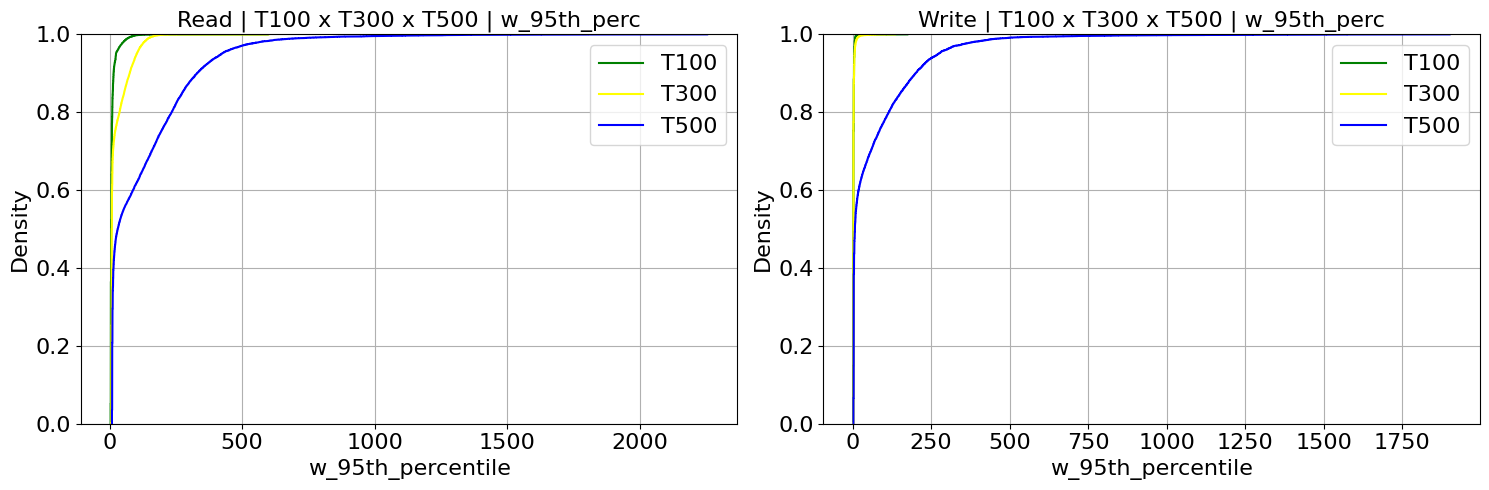

In [15]:
# 99th_percentile t100
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.ecdfplot(data=y_t100_r, x='w_95th_percentile', color="green", label='T100', ax=axes[0])
sns.ecdfplot(data=y_t300_r, x='w_95th_percentile', color="yellow", label='T300', ax=axes[0])
sns.ecdfplot(data=y_t500_r, x='w_95th_percentile', color="blue", label='T500', ax=axes[0])
axes[0].set_title("Read | T100 x T300 x T500 | w_95th_perc", fontsize=16)
axes[0].tick_params(axis='both', labelsize=16)
axes[0].set_ylabel("Density", fontsize=16)
axes[0].set_xlabel("w_95th_percentile", fontsize=16)
axes[0].grid(True)
axes[0].legend(fontsize=16)
# axes[0].set_xlim(0.0, 500)

sns.ecdfplot(data=y_t100_w, x='w_95th_percentile', color="green", label='T100', ax=axes[1])
sns.ecdfplot(data=y_t300_w, x='w_95th_percentile', color="yellow", label='T300', ax=axes[1])
sns.ecdfplot(data=y_t500_w, x='w_95th_percentile', color="blue", label='T500', ax=axes[1])
axes[1].set_title("Write | T100 x T300 x T500 | w_95th_perc", fontsize=16)
axes[1].tick_params(axis='both', labelsize=16)
axes[1].set_ylabel("Density", fontsize=16)
axes[1].set_xlabel("w_95th_percentile", fontsize=16)
axes[1].grid(True)
axes[1].legend(fontsize=16)
# axes[1].set_xlim(0.0, 500)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

fig.savefig(f'images/exp_90c_11h_v3/cdf_ts_rw.png', dpi=fig.dpi, format='png')

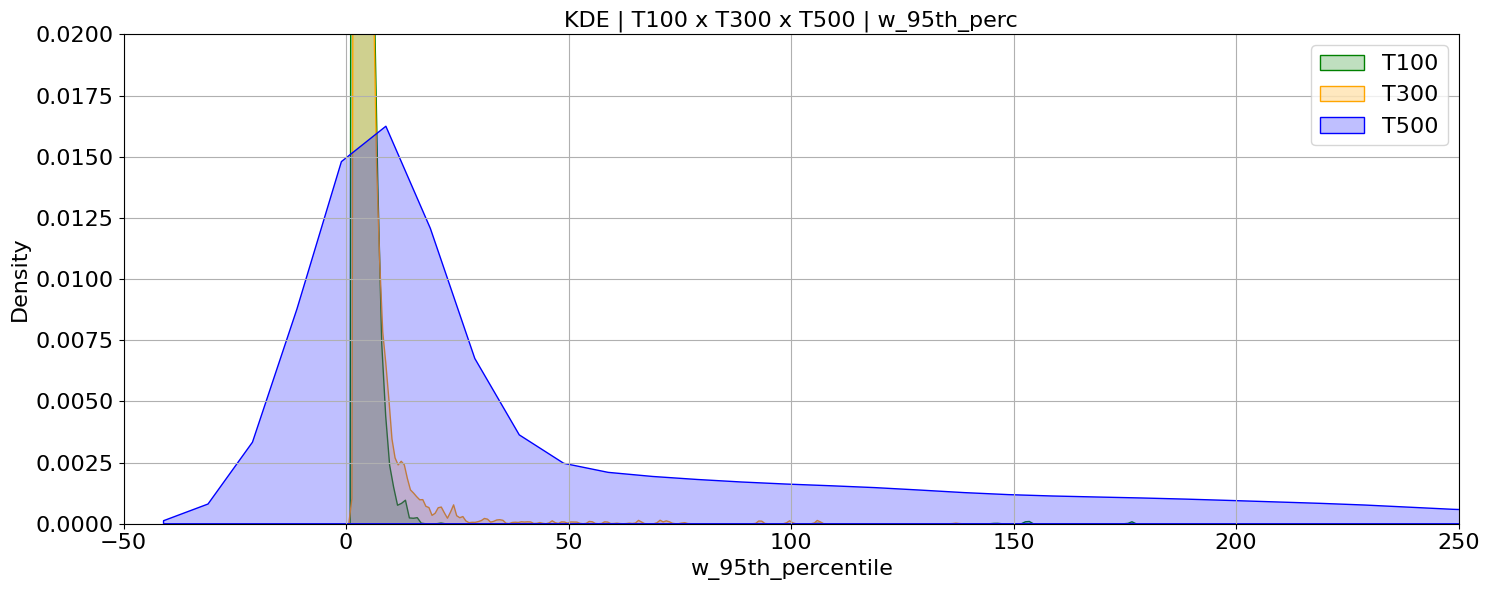

In [13]:
# 99th_percentile t300
fig, axes = plt.subplots(1, 1, figsize=(15, 6))
sns.kdeplot(y_t100_w['w_95th_percentile'], color="green", label='T100',fill=True, ax=axes)
sns.kdeplot(y_t300_w['w_95th_percentile'], color="orange", label='T300',fill=True, ax=axes)
sns.kdeplot(y_t500_w['w_95th_percentile'], color="blue", label='T500',fill=True, ax=axes)
axes.set_title("KDE | T100 x T300 x T500 | w_95th_perc", fontsize=16)
axes.tick_params(axis='both', labelsize=16)
axes.set_ylabel("Density", fontsize=16)
axes.set_xlabel("w_95th_percentile", fontsize=16)
axes.set_ylim(0.0, 0.02)
axes.set_xlim(-50.0, 250)
axes.grid(True)
axes.legend(fontsize=16)

# sns.kdeplot(y_t100_w['w_95th_percentile'], color="green", label='T100',fill=True, ax=axes[0])
# sns.kdeplot(y_t300_w['w_95th_percentile'], color="orange", label='T300',fill=True, ax=axes[0])
# sns.kdeplot(y_t500_w['w_95th_percentile'], color="blue", label='T500',fill=True, ax=axes[0])
# axes[0].set_title("KDE | T100 x T300 x T500 | w_95th_perc")
# axes[0].set_ylim(0.0, 0.02)
# axes[0].set_xlim(-50.0, 250)
# axes[0].grid(True)
# axes[0].legend()

# sns.ecdfplot(data=y_t100_w, x='w_95th_percentile', color="green", label='T100', ax=axes[1])
# sns.ecdfplot(data=y_t300_w, x='w_95th_percentile', color="orange", label='T300', ax=axes[1])
# sns.ecdfplot(data=y_t500_w, x='w_95th_percentile', color="blue", label='T500', ax=axes[1])
# axes[1].set_title("CDF | T100 x T300 x T500 | w_95th_perc")
# axes[1].grid(True)
# axes[1].legend()

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

fig.savefig(f'images/exp_90c_11h_v3/kde_cfd_write_ts.png', dpi=fig.dpi, format='png')

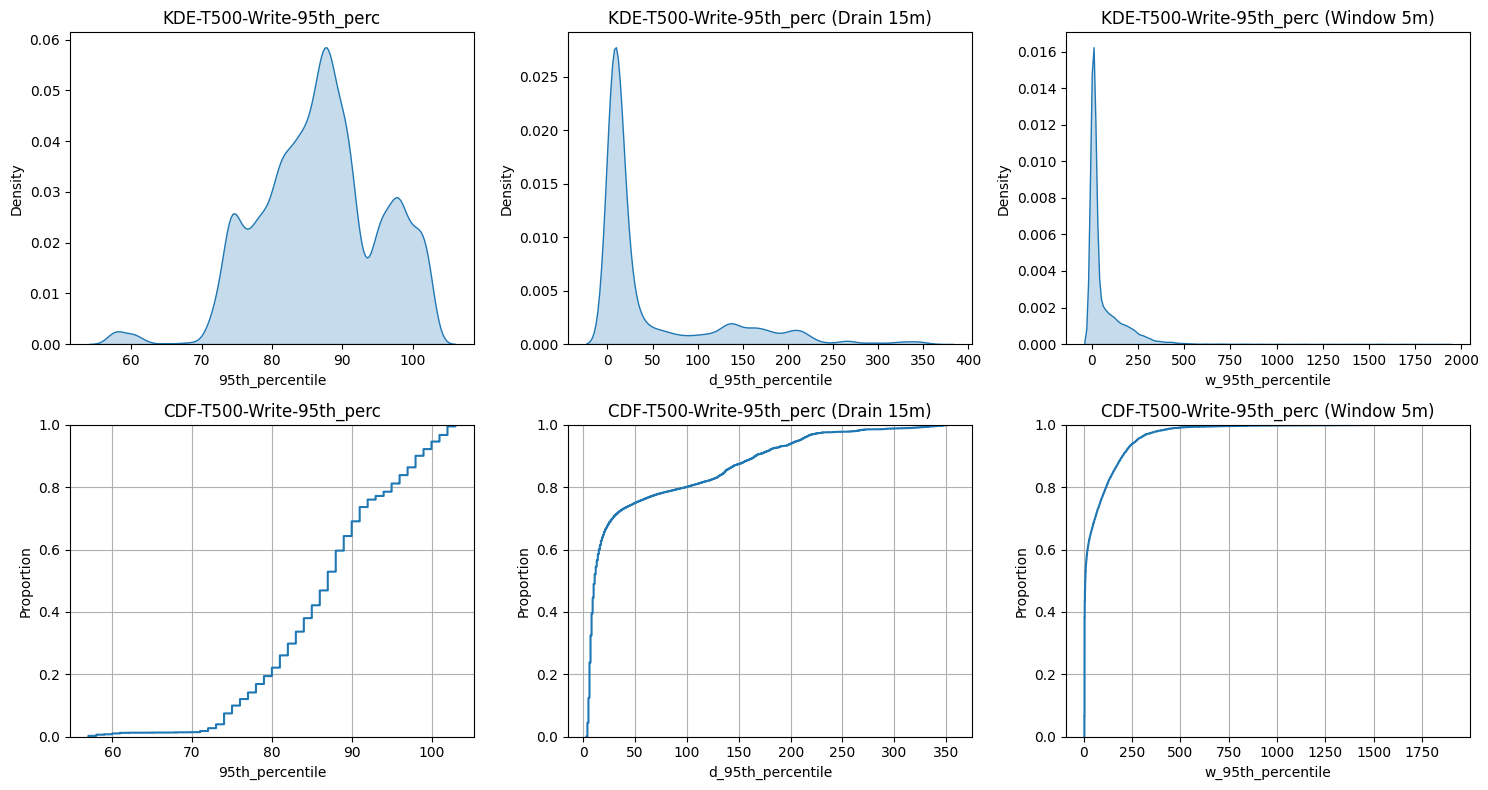

In [19]:
# 99th_percentile t500
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sns.kdeplot(y_t500['95th_percentile'],fill=True, ax=axes[0,0])
axes[0,0].set_title("KDE-T500-Write-95th_perc")

sns.kdeplot(y_t500['d_95th_percentile'],fill=True, ax=axes[0,1])
axes[0,1].set_title("KDE-T500-Write-95th_perc (Drain 15m)")

sns.kdeplot(y_t500['w_95th_percentile'],fill=True, ax=axes[0,2])
axes[0,2].set_title("KDE-T500-Write-95th_perc (Window 5m)")

sns.ecdfplot(data=y_t500, x='95th_percentile', ax=axes[1,0])
axes[1,0].set_title("CDF-T500-Write-95th_perc")
axes[1,0].grid(True)

sns.ecdfplot(data=y_t500, x='d_95th_percentile', ax=axes[1,1])
axes[1,1].set_title("CDF-T500-Write-95th_perc (Drain 15m)")
axes[1,1].grid(True)

sns.ecdfplot(data=y_t500, x='w_95th_percentile', ax=axes[1,2])
axes[1,2].set_title("CDF-T500-Write-95th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

# KDE sobrepost t100, t300 e t500.

In [6]:
def get_select_k_best_ds(x, y, k):
    selector = SelectKBest(f_regression, k=k)
    k_best_ds = selector.fit_transform(x, y)

    # Get a boolean mask of selected features
    selected_features_mask = selector.get_support()

    # Get the names of the selected features
    selected_feature_names = x.columns[selected_features_mask]
    print(selected_feature_names)

    k_best_ds = pd.DataFrame(k_best_ds, columns=selected_feature_names, index=x.index)
    print(k_best_ds.shape)
    k_best_ds.head(5)
    return k_best_ds

# Random Forest training using all features and k best features...

## train 70%, test 30%

In [8]:
def kfold_train_and_generate_plots(X, y, y_col, kfold, title, image_path):
    random_forest_model = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)
    
    # Set up K-fold cross-validation
    kf = KFold(n_splits=kfold, shuffle=True, random_state=42) # 5

    scores = []
    fig, axes = plt.subplots(kfold, 2, figsize=(15, 20))
    time = datetime.datetime.now(tz=datetime.timezone.utc)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Create splits
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx][y_col], y.iloc[test_idx][y_col]
    
        sns.ecdfplot(data=y, x=y_col, label='y', ax=axes[fold,0])
        sns.ecdfplot(x=y_train, label=f'y_train_{fold}', ax=axes[fold,0])
        sns.ecdfplot(x=y_test, label=f'y_test_{fold}', ax=axes[fold,0])
        axes[fold,0].set_title(f"CDF-{title}-F{fold}")
        axes[fold,0].grid(True)
        axes[fold,0].legend()
    
        sns.kdeplot(y[y_col],fill=True, label='y', ax=axes[fold,1])
        sns.kdeplot(y_train,fill=True, label=f'y_train_{fold}', ax=axes[fold,1])
        sns.kdeplot(y_test,fill=True, label=f'y_test_{fold}', ax=axes[fold,1])
        axes[fold,1].set_title(f"KDE-{title}-F{fold}")
        axes[fold,1].legend()
    
        # Train model
        random_forest_model.fit(X_train, y_train)
    
        # Predict
        y_pred = random_forest_model.predict(X_test)
    
        # Compute NMAE
        nmae_value = nmae(y_pred, y_test)
    
        scores.append(nmae_value)
    
    print(f'T100 - Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')
    
    for i, s in enumerate(scores):
        print(f"Fold {i+1}: {s:.2%}")
    
    print(f"Mean NMAE: {np.mean(scores):.2%}\n")

    plt.tight_layout()
    plt.show()

    fig.savefig(f'{image_path}/{title}.png', dpi=fig.dpi, format='png')

## T100

T100 - Rand. Forest Training time: 232.518762s
Fold 1: 0.08%
Fold 2: 0.09%
Fold 3: 0.08%
Mean NMAE: 0.08%



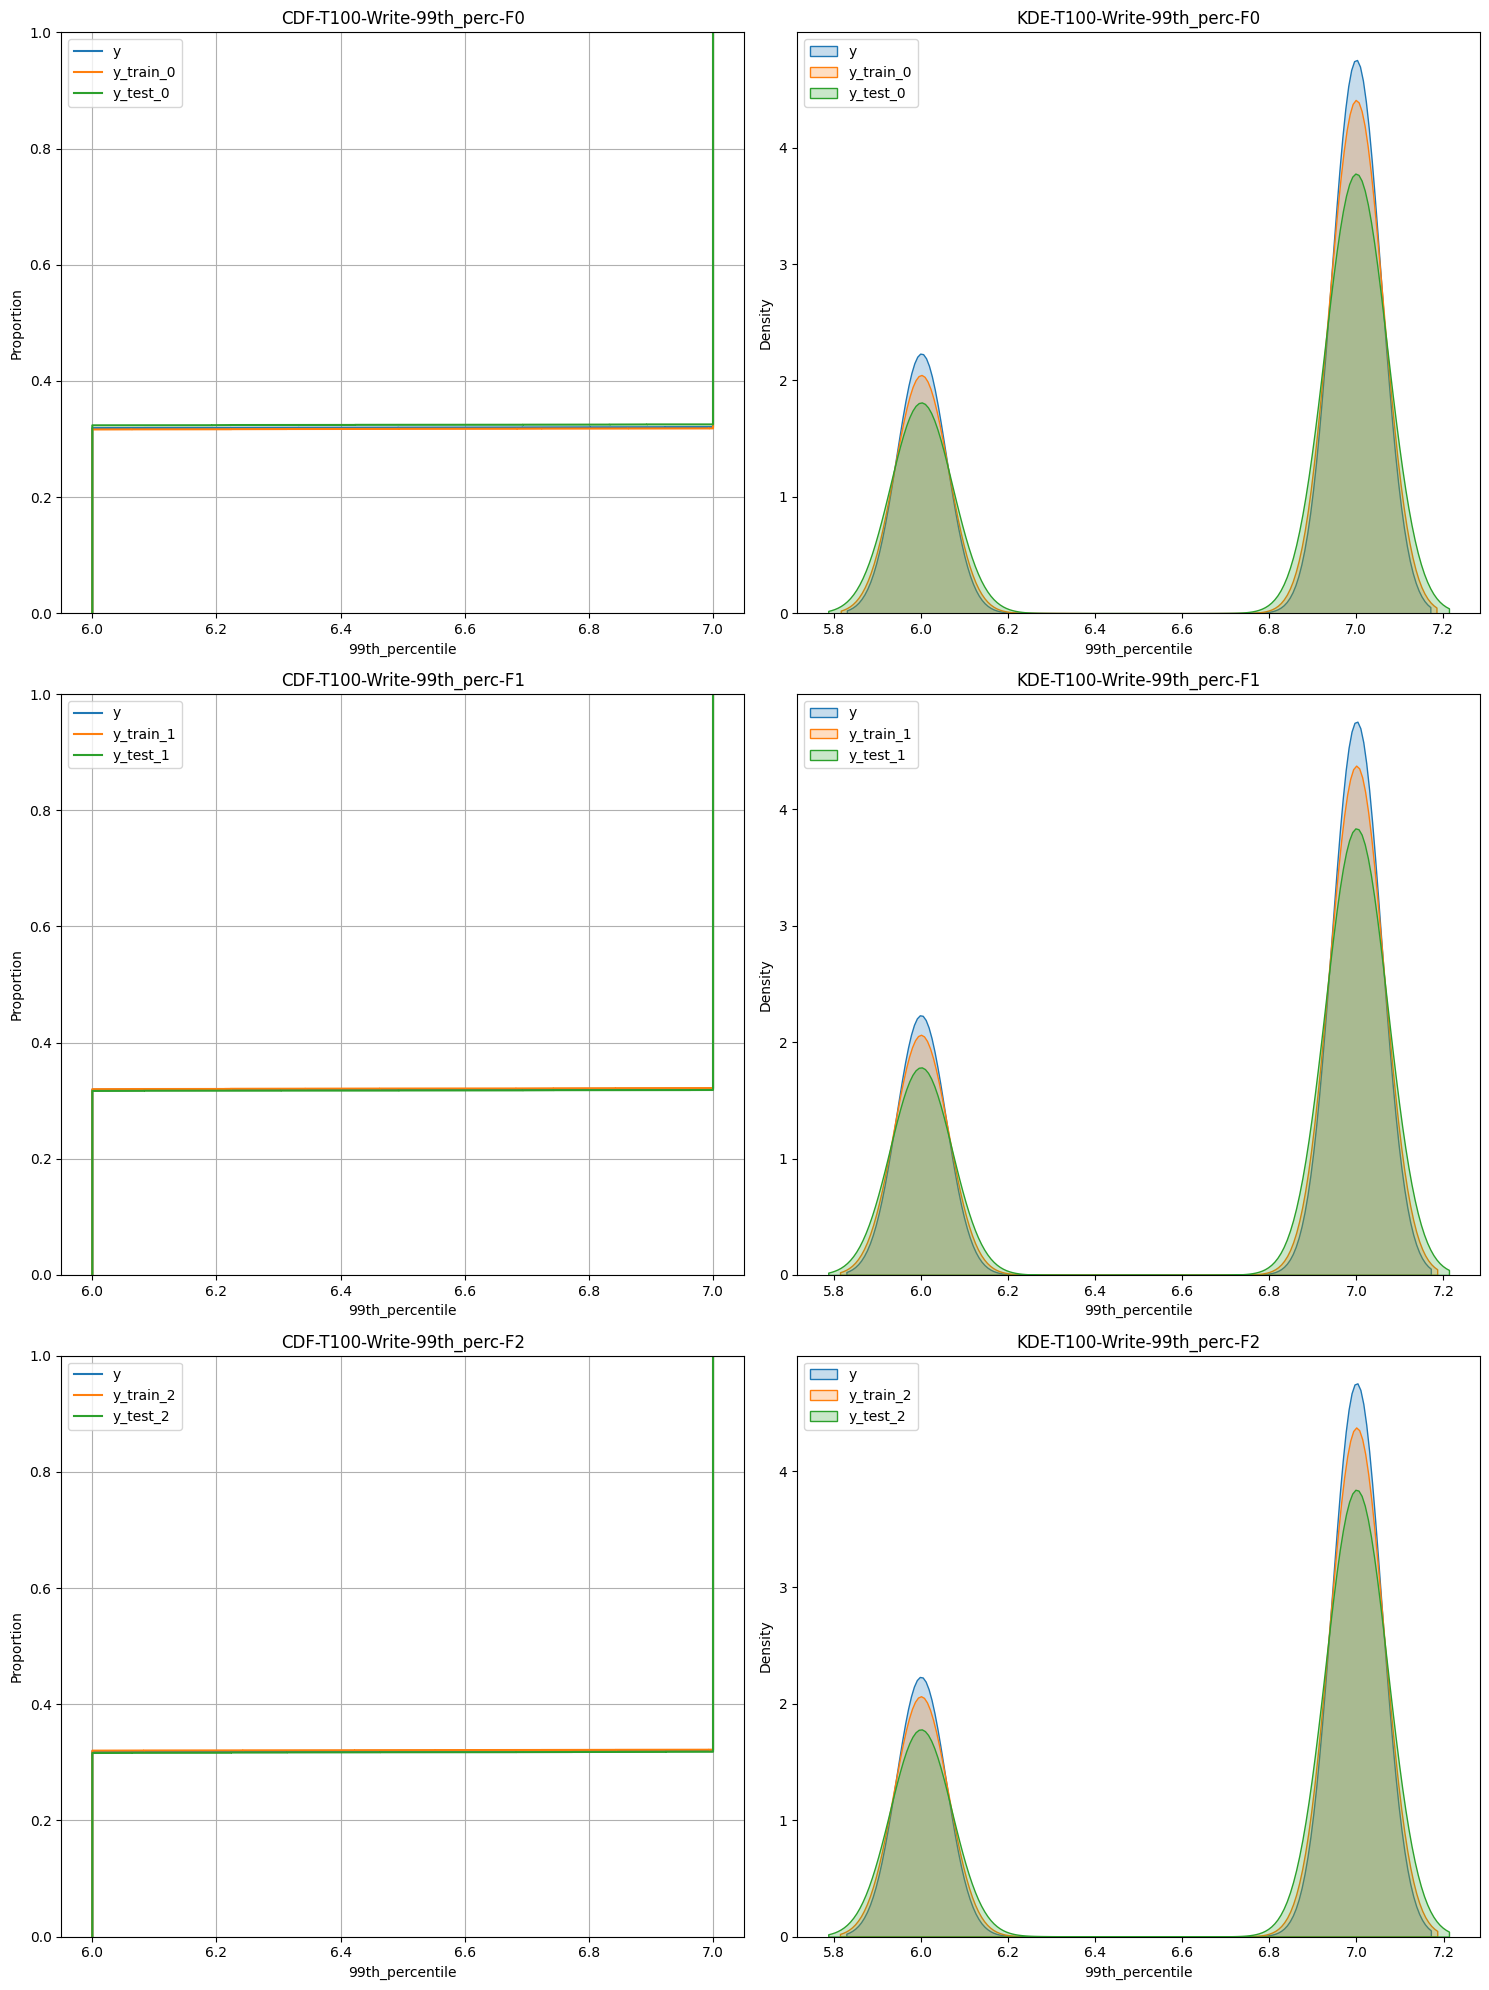

In [9]:
# Full dataset - wihout normalization...
kfold_train_and_generate_plots(x_t100, y_t100, "99th_percentile", 3, "T100-Write-99th_perc", "images/exp_90c_11h_v3")

T100 - Rand. Forest Training time: 333.104282s
Fold 1: 2.71%
Fold 2: 3.16%
Fold 3: 3.08%
Mean NMAE: 2.98%



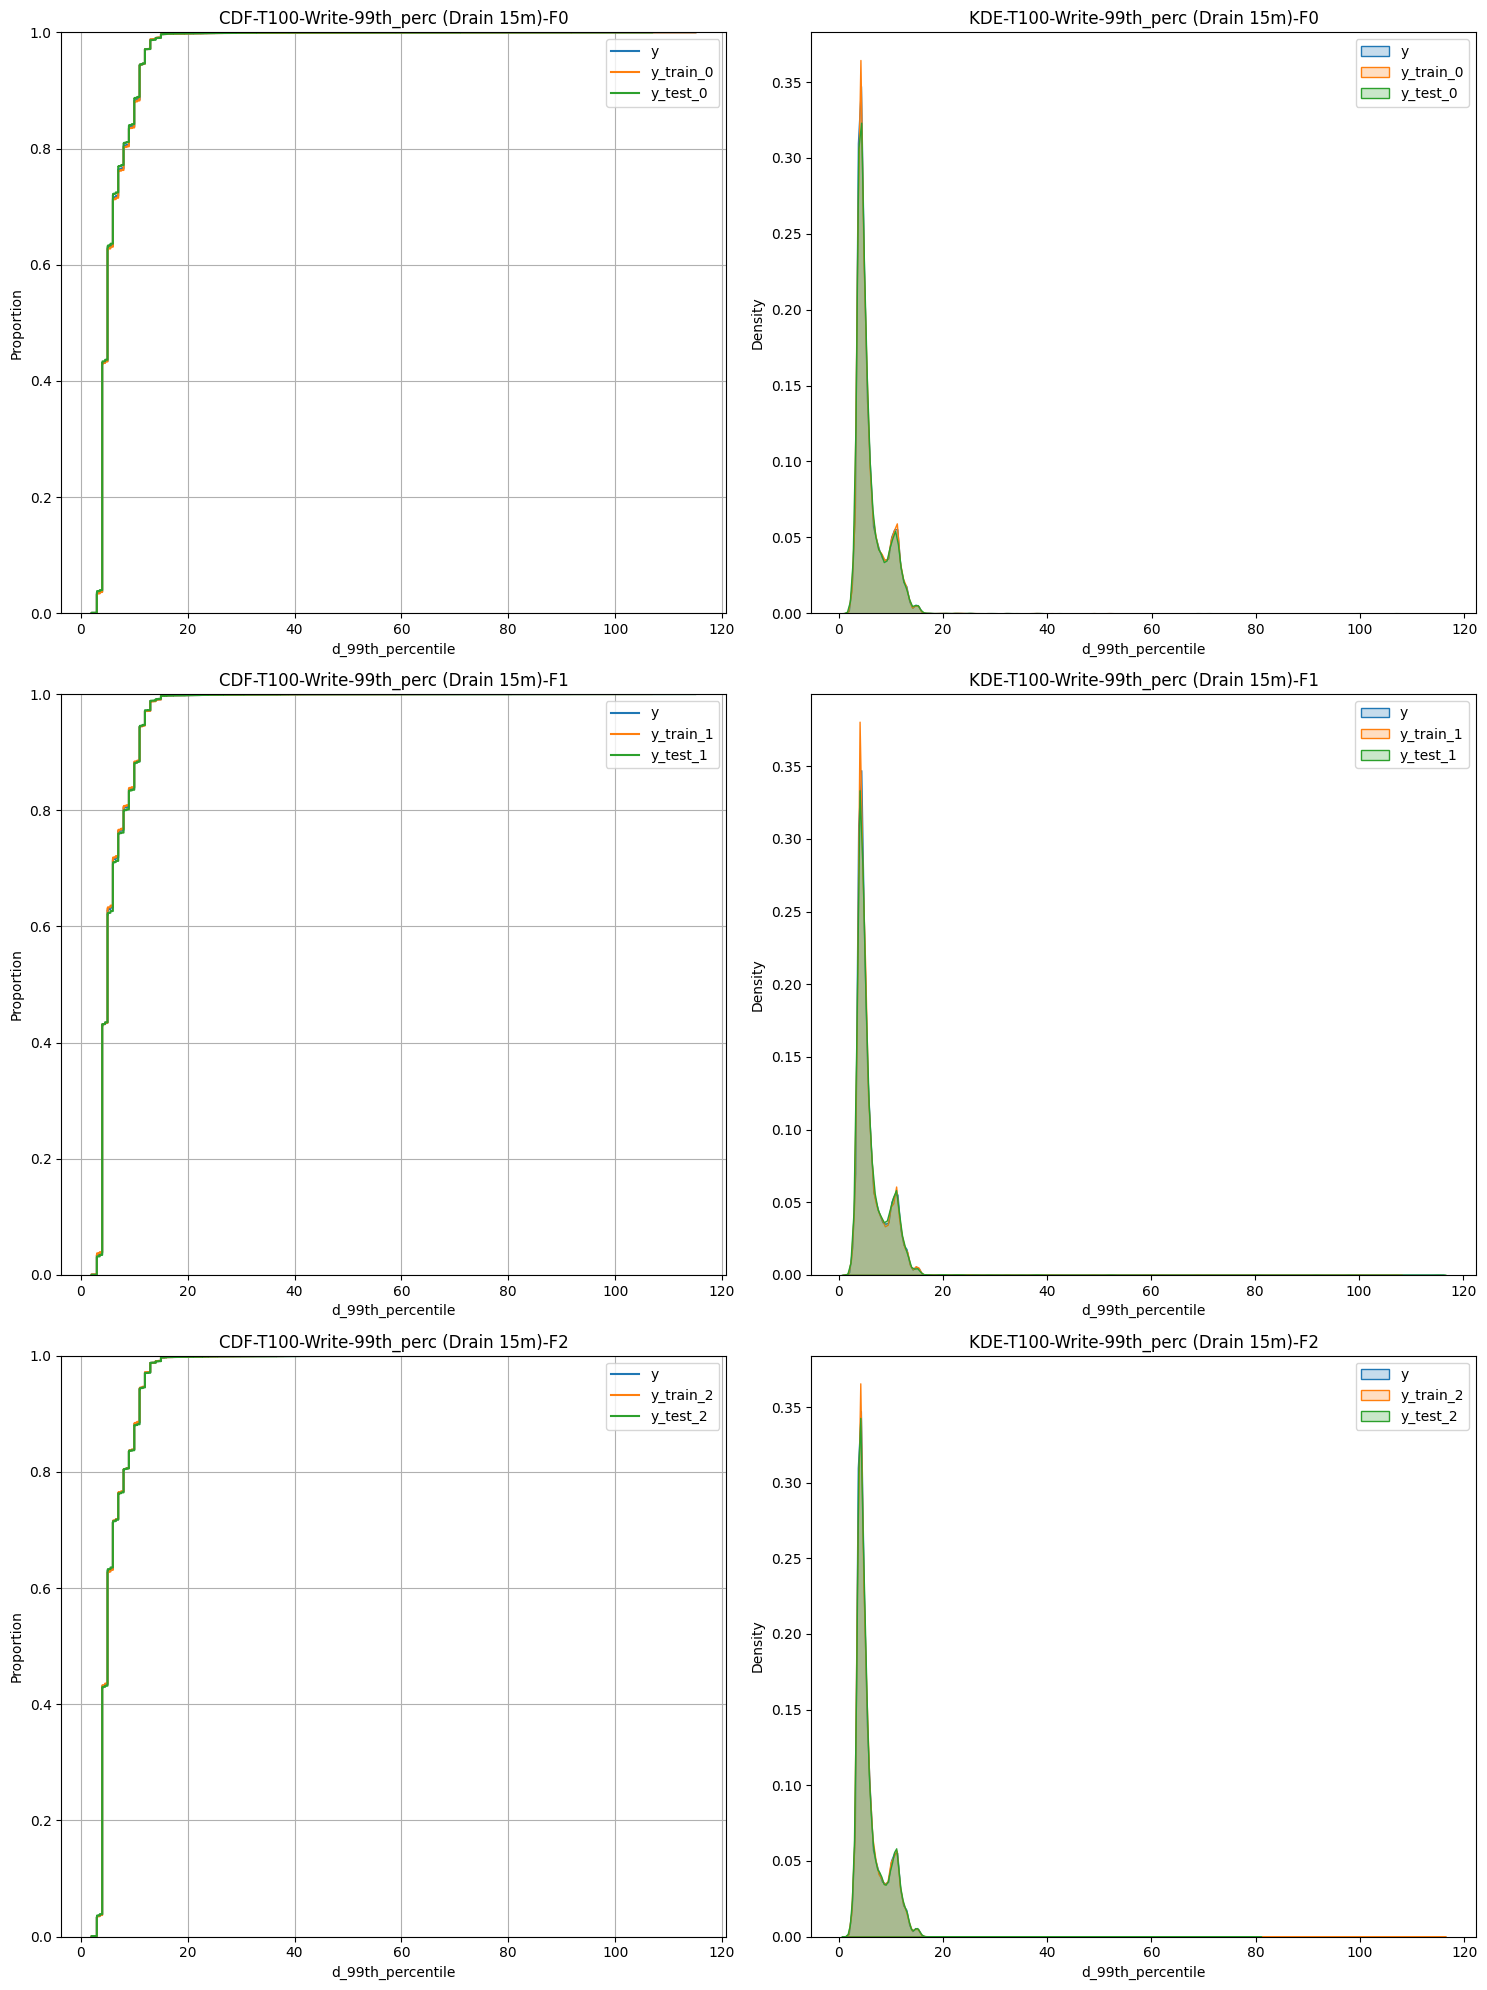

In [10]:
kfold_train_and_generate_plots(x_t100, y_t100, "d_99th_percentile", 3, "T100-Write-99th_perc (Drain 15m)", "images/exp_90c_11h_v3")

T100 - Rand. Forest Training time: 620.577563s
Fold 1: 61.59%
Fold 2: 61.01%
Fold 3: 61.04%
Mean NMAE: 61.21%



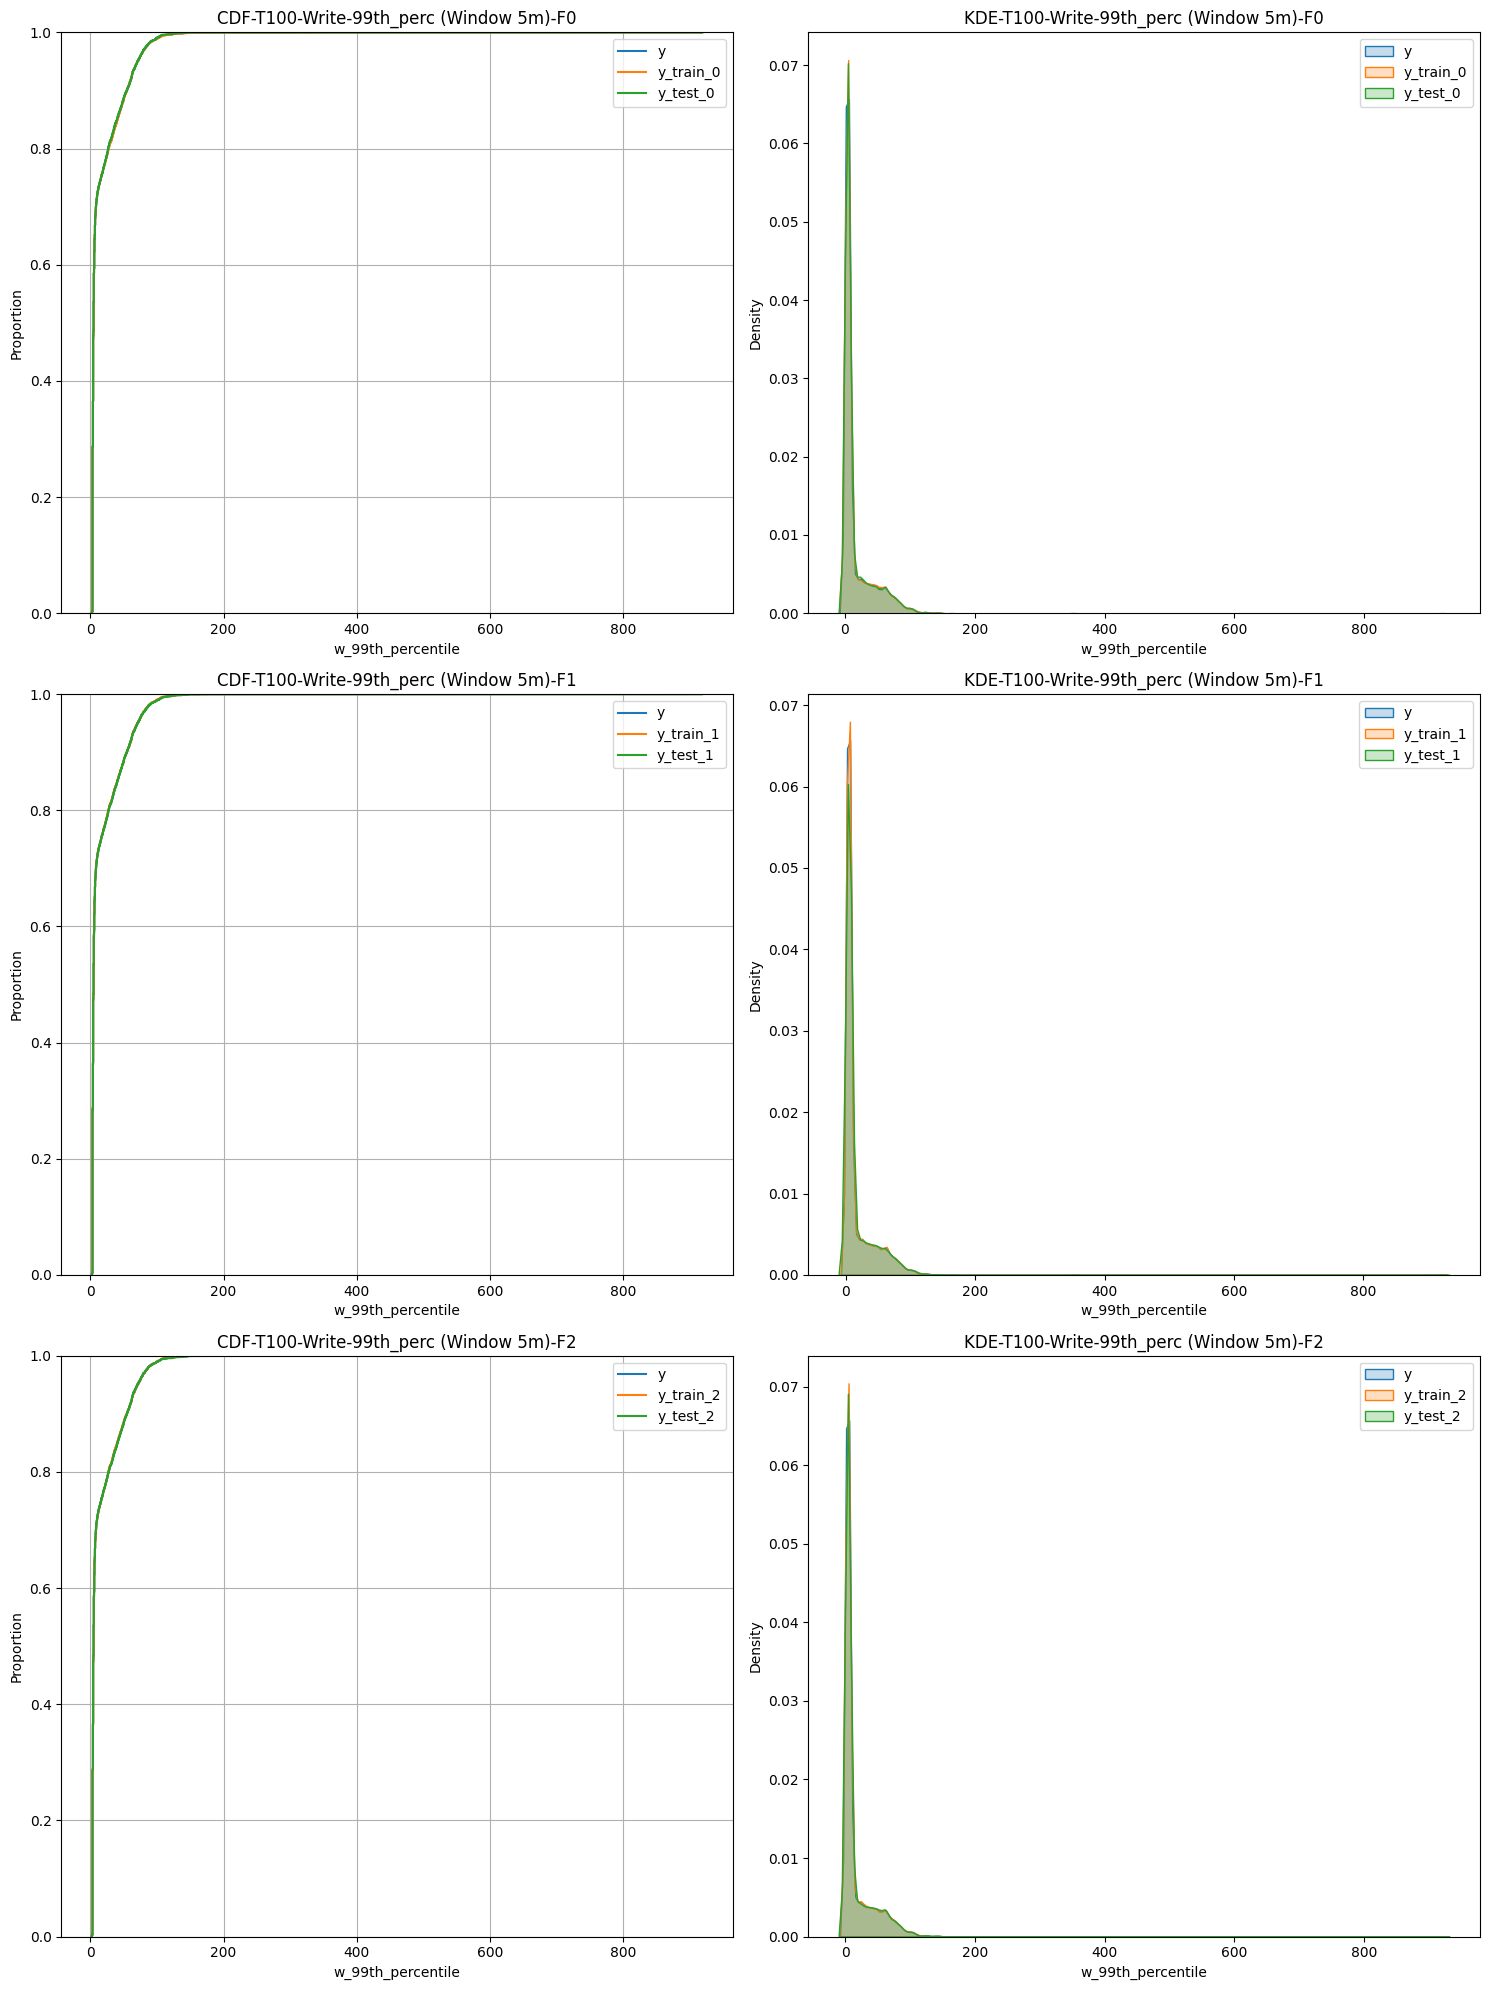

In [11]:

kfold_train_and_generate_plots(x_t100, y_t100, "w_99th_percentile", 3, "T100-Write-99th_perc (Window 5m)", "images/exp_90c_11h_v3")

In [ ]:
# using T100 w_99th_percentile
y_target = y_t100[["timestamp", "w_99th_percentile"]].copy()
df_merged = pd.merge(x_t100, y_target, on="timestamp", how="inner")

print(f"Min {df_merged["w_99th_percentile"].min()} | Max {df_merged[target_col].max()}")

# df_filtered = df_merged[df_merged["w_99th_percentile"] <= 20.0]
df_filtered = df_merged

y = df_filtered[["timestamp", "w_99th_percentile"]].copy()
X = df_filtered.drop(columns=["w_99th_percentile"])

kfold_train_and_generate_plots(X, y, "w_99th_percentile", 3, "T100-Filtered-Write-99th_perc (Window 5m)", "images/exp_90c_11h")

## T300

In [ ]:
# Full dataset - wihout normalization...
kfold_train_and_generate_plots(x_t300, y_t300, "99th_percentile", 3, "T300-Write-99th_perc", "images/exp_90c_11h")

In [ ]:
kfold_train_and_generate_plots(x_t300, y_t300, "d_99th_percentile", 3, "T300-Write-99th_perc (Drain 15m)", "images/exp_90c_11h")

In [ ]:
kfold_train_and_generate_plots(x_t300, y_t300, "w_99th_percentile", 3, "T300-Write-99th_perc (Window 5m)", "images/exp_90c_11h")

## T500

In [ ]:
# Full dataset - wihout normalization...
kfold_train_and_generate_plots(x_t500, y_t500, "99th_percentile", 3, "T500-Write-99th_perc", "images/exp_90c_11h")

In [ ]:
kfold_train_and_generate_plots(x_t500, y_t500, "d_99th_percentile", 3, "T500-Write-99th_perc (Drain 15m)", "images/exp_90c_11h")

In [ ]:
kfold_train_and_generate_plots(x_t500, y_t500, "w_99th_percentile", 3, "T500-Write-99th_perc (Window 5m)", "images/exp_90c_11h")

## Other models...

In [11]:
# Full dataset, using xgboost

# 3. Initialize the XGBoost Regressor model
# objective='reg:squarederror' is the default for regression, but explicitly setting it is good practice.
# n_estimators controls the number of boosting rounds (trees).
# random_state for reproducibility.
model = xgb.XGBRegressor(n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    eval_metric=mean_absolute_error)

target_col = "w_99th_percentile"
# using T100 w_99th_percentile
y_target = y_t100[["timestamp", target_col]].copy()
df_merged = pd.merge(x_t100, y_target, on="timestamp", how="inner")

print(f"Min {df_merged[target_col].min()} | Max {df_merged[target_col].max()}")

df_filtered = df_merged[df_merged[target_col] <= 20.0]

y = df_filtered[[target_col]].copy()
X = df_filtered.drop(columns=[target_col])

x_train, x_test, y_train, y_test = train_test_split(X, y[target_col].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'XGBoost Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Min 2.0 | Max 114.296666666666
XGBoost Training time: 84.386186s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 12.94%


In [14]:
# 3. Initialize the XGBoost Regressor model
# objective='reg:squarederror' is the default for regression, but explicitly setting it is good practice.
# n_estimators controls the number of boosting rounds (trees).
# random_state for reproducibility.
model = xgb.XGBRegressor(n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    eval_metric=mean_absolute_error)

# using T300 w_99th_percentile
y_target = y_t300[["timestamp", target_col]].copy()
df_merged = pd.merge(x_t300, y_target, on="timestamp", how="inner")

print(f"Min {df_merged[target_col].min()} | Max {df_merged[target_col].max()}")

df_filtered = df_merged

y = df_filtered[[target_col]].copy()
X = df_filtered.drop(columns=[target_col])

x_train, x_test, y_train, y_test = train_test_split(X, y[target_col].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'XGBoost Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Min 3.0 | Max 213.643333333333
XGBoost Training time: 87.436976s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 12.17%


In [15]:
# 3. Initialize the XGBoost Regressor model
# objective='reg:squarederror' is the default for regression, but explicitly setting it is good practice.
# n_estimators controls the number of boosting rounds (trees).
# random_state for reproducibility.
model = xgb.XGBRegressor(n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    eval_metric=mean_absolute_error)

# using T500 w_99th_percentile
y_target = y_t500[["timestamp", target_col]].copy()
df_merged = pd.merge(x_t500, y_target, on="timestamp", how="inner")

print(f"Min {df_merged[target_col].min()} | Max {df_merged[target_col].max()}")

df_filtered = df_merged

y = df_filtered[[target_col]].copy()
X = df_filtered.drop(columns=[target_col])

x_train, x_test, y_train, y_test = train_test_split(X, y[target_col].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'XGBoost Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Min 3.6633333333333 | Max 420.653333333333
XGBoost Training time: 95.77342s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 9.53%


# LightGBM

In [ ]:
# using T100 w_99th_percentile
# target_col = "w_99th_percentile"

# y_target = y_t100[["timestamp", target_col]].copy()
# df_merged = pd.merge(x_t100, y_target, on="timestamp", how="inner")

# print(f"Min {df_merged[target_col].min()} | Max {df_merged[target_col].max()}")

# # df_filtered = df_merged
# df_filtered = df_merged[df_merged[target_col] <= 20.0]

# y = df_filtered[[target_col]].copy()
# X = df_filtered.drop(columns=[target_col])

# x_train, x_test, y_train, y_test = train_test_split(X, y[target_col].to_numpy(), test_size=0.30, random_state=42)

# # ----------------------------
# # 4. Create the LightGBM dataset
# # ----------------------------
# train_data = lgb.Dataset(x_train, label=y_train)
# valid_data = lgb.Dataset(x_test, label=y_test)

# # ----------------------------
# # 5. Define model parameters
# # ----------------------------
# params = {
#     "objective": "regression",
#     "metric": "mae",
#     "boosting_type": "gbdt",
#     "learning_rate": 0.03,
#     "num_leaves": 128,
#     "max_depth": -1,
#     "min_data_in_leaf": 50,
#     "feature_fraction": 0.8,
#     "bagging_fraction": 0.8,
#     "bagging_freq": 5,
#     "lambda_l1": 0.5,
#     "lambda_l2": 1.0,
#     "verbosity": -1,
#     "seed": 42
# }

# # ----------------------------
# # 6. Train model
# # ----------------------------
# model = lgb.train(
#     params,
#     train_data,
#     valid_sets=[train_data, valid_data],
#     num_boost_round=1000,
#     callbacks=[lgb.early_stopping(stopping_rounds=50)]
# )

# # ----------------------------
# # 7. Predict
# # ----------------------------
# pred = model.predict(x_test)

# ----------------------------
# 8. Evaluate (MAE)
# ----------------------------
# mae = mean_absolute_error(y_test, pred)
# print("MAE:", mae)
# print(f"NMAE: {nmae(pred, y_test):.2%}")

# Get feature importances and names
feature_importances = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()exp_90c_11h

# Create a DataFrame for sorting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance and get the top 100 features
top_100_features = importance_df.sort_values(by='Importance', ascending=False).head(100)

print("Top 100 Features by Importance:")
print(top_100_features['Feature'].tolist())


# Assuming 'model' is a trained LightGBM model
# lgb.plot_importance(model, importance_type='gain', max_num_features=100, figsize=(10, 6))
# plt.title("LightGBM Feature Importance (Gain)")
# plt.show()

# KDE for read dataset metrics

176.399999999999


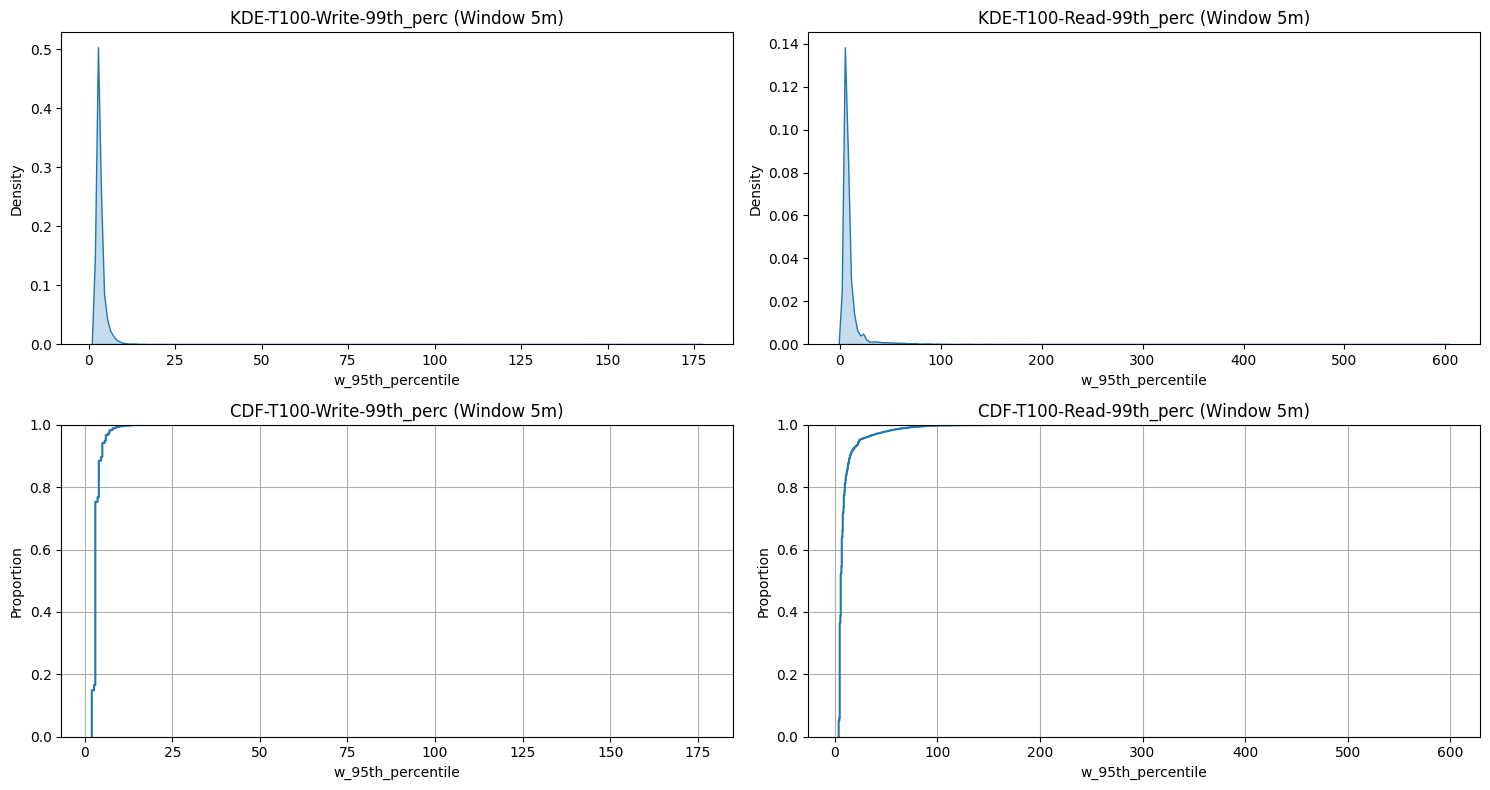

In [25]:
# 99th_percentile t100
print(y_t100['w_95th_percentile'].max())

fig, axes = plt.subplots(2, 2, figsize=(15, 8))
sns.kdeplot(y_t100['w_95th_percentile'],fill=True, ax=axes[0,0])
axes[0,0].set_title("KDE-T100-Write-99th_perc (Window 5m)")

sns.kdeplot(y_t100_r['w_95th_percentile'],fill=True, ax=axes[0,1])
axes[0,1].set_title("KDE-T100-Read-99th_perc (Window 5m)")

sns.ecdfplot(data=y_t100, x='w_95th_percentile', ax=axes[1,0])
axes[1,0].set_title("CDF-T100-Write-99th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,0].grid(True)

sns.ecdfplot(data=y_t100_r, x='w_95th_percentile', ax=axes[1,1])
axes[1,1].set_title("CDF-T100-Read-99th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,1].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

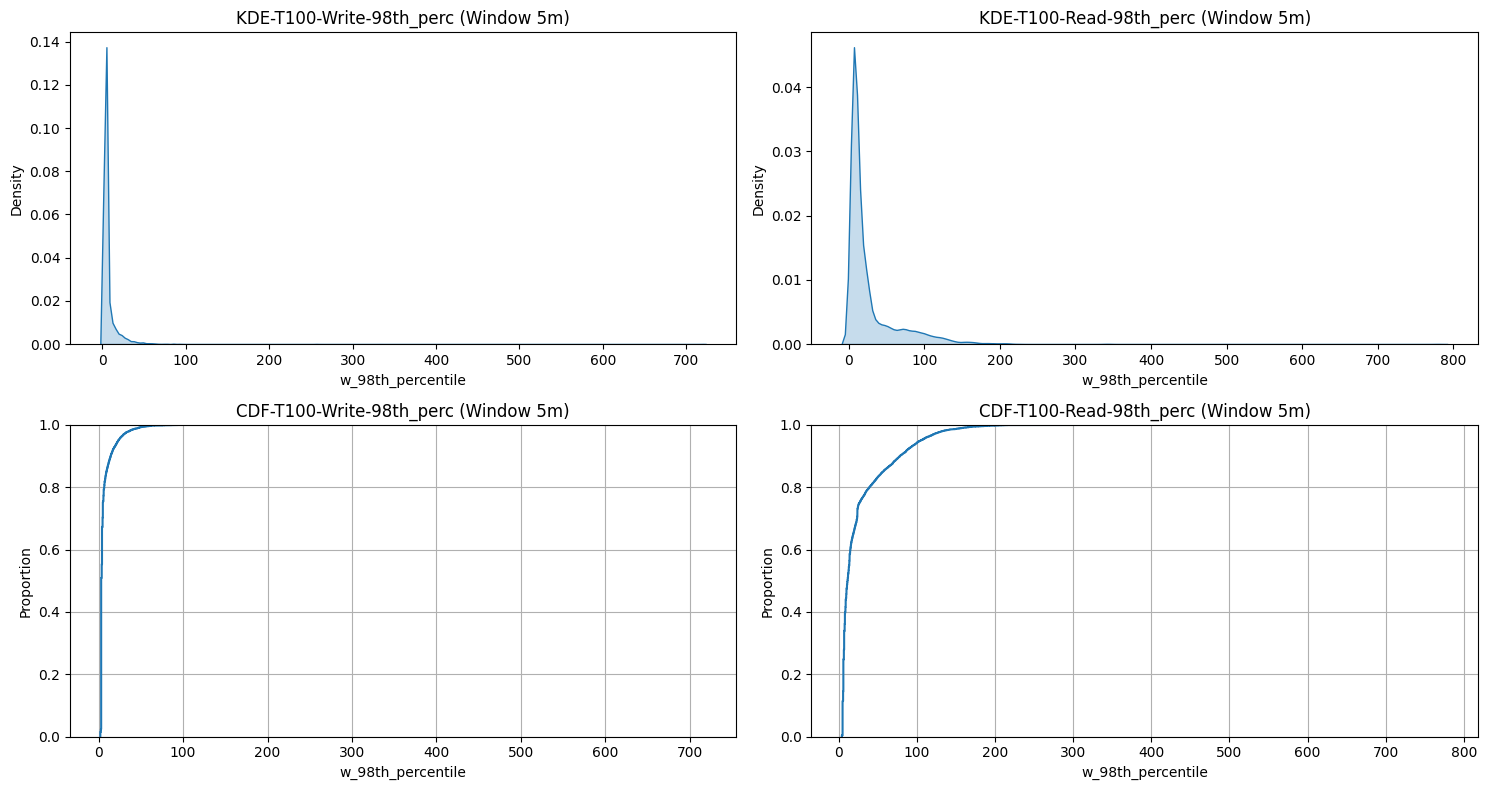

In [14]:
# 99th_percentile t100
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
sns.kdeplot(y_t100['w_98th_percentile'],fill=True, ax=axes[0,0])
axes[0,0].set_title("KDE-T100-Write-98th_perc (Window 5m)")

sns.kdeplot(y_t100_r['w_98th_percentile'],fill=True, ax=axes[0,1])
axes[0,1].set_title("KDE-T100-Read-98th_perc (Window 5m)")

sns.ecdfplot(data=y_t100, x='w_98th_percentile', ax=axes[1,0])
axes[1,0].set_title("CDF-T100-Write-98th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,0].grid(True)

sns.ecdfplot(data=y_t100_r, x='w_98th_percentile', ax=axes[1,1])
axes[1,1].set_title("CDF-T100-Read-98th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,1].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In [27]:
# Calculate the 99th percentile threshold value
# 'linear' is the default interpolation method
percentile_99_value = np.percentile(y_t500['w_95th_percentile'], 99, method='linear') 

# Count how many samples in the original data are less than this value
# Note: The '<' is typically used as percentile is the value *below* which a percentage falls
count_actual = np.sum(y_t500['w_95th_percentile'] >= percentile_99_value)

print(f"The 95th percentile threshold value is: {percentile_99_value}")
print(f"Actual count of samples strictly below the threshold: {count_actual}")

The 95th percentile threshold value is: 327.25
Actual count of samples strictly below the threshold: 371


The 95th percentile threshold value is: 7.0
Actual count of samples strictly below the threshold: 1011
The 95th percentile threshold value is: 10.65
Actual count of samples strictly below the threshold: 738
The 95th percentile threshold value is: 381.65
Actual count of samples strictly below the threshold: 737


KeyError: 'target_cleaned'

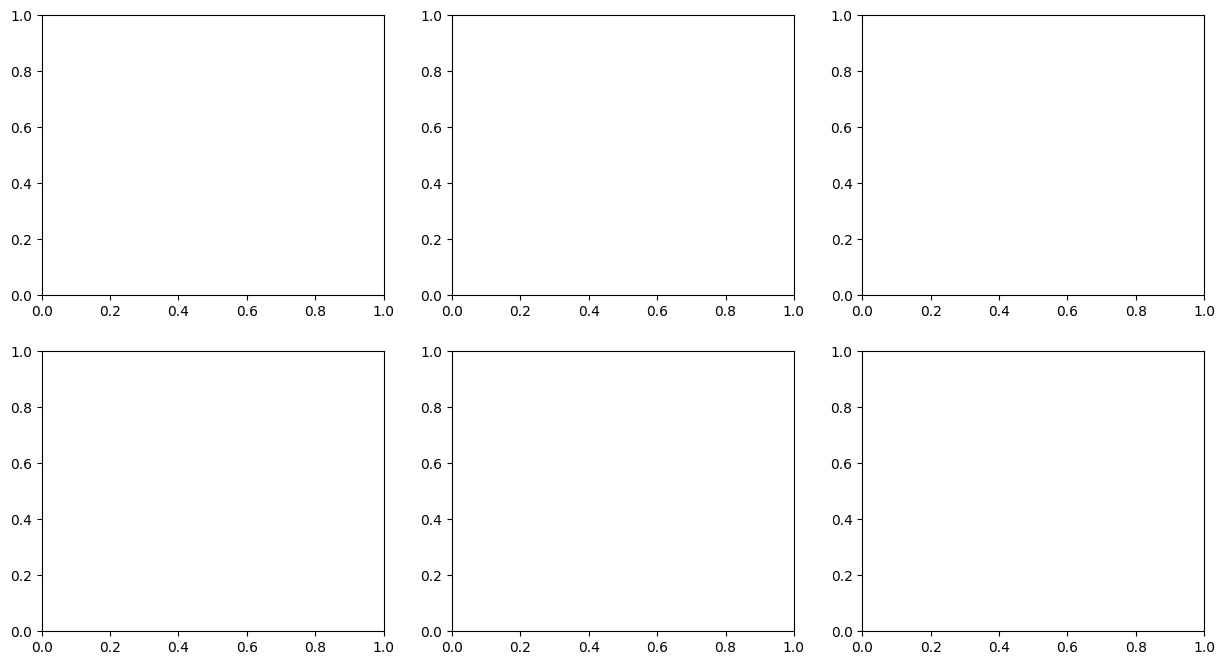

In [61]:
# concat x and y, filtering by 99 percentil on y and split to x and y again
x_t100_f, y_t100_f = replace_outliers_zscore(x_t100, y_t100, 'w_95th_percentile')
x_t300_f, y_t300_f = replace_outliers_zscore(x_t300, y_t300, 'w_95th_percentile')
x_t500_f, y_t500_f = replace_outliers_zscore(x_t500, y_t500, 'w_95th_percentile')

# w_95th_percentile - t100 x t300 x t500
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sns.kdeplot(y_t100_f['target_cleaned'],fill=True, ax=axes[0, 0])
axes[0, 0].set_title("KDE-T100-Write-w_95th_perc")

sns.kdeplot(y_t300_f['target_cleaned'],fill=True, ax=axes[0, 1])
axes[0, 1].set_title("KDE-T300-Write-w_95th_perc")

sns.kdeplot(y_t500_f['target_cleaned'],fill=True, ax=axes[0, 2])
axes[0, 2].set_title("KDE-T500-Write-w_95th_perc")

sns.ecdfplot(data=y_t100_f['target_cleaned'], ax=axes[1,0])
axes[1,0].set_title("CDF-T100-Write-w_95th_perc")
axes[1,0].grid(True)

sns.ecdfplot(data=y_t300_f['target_cleaned'], ax=axes[1,1])
axes[1,1].set_title("CDF-T300-Write-w_95th_perc")
axes[1,1].grid(True)

sns.ecdfplot(data=y_t500_f['target_cleaned'], ax=axes[1,2])
axes[1,2].set_title("CDF-T500-Write-w_95th_perc")
# axes[2].set_xlim(0.0, 50)
axes[1,2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

The 95th percentile threshold value is: 7.0
Actual count of samples strictly below the threshold: 1011
The 95th percentile threshold value is: 10.65
Actual count of samples strictly below the threshold: 738
The 95th percentile threshold value is: 381.65
Actual count of samples strictly below the threshold: 737


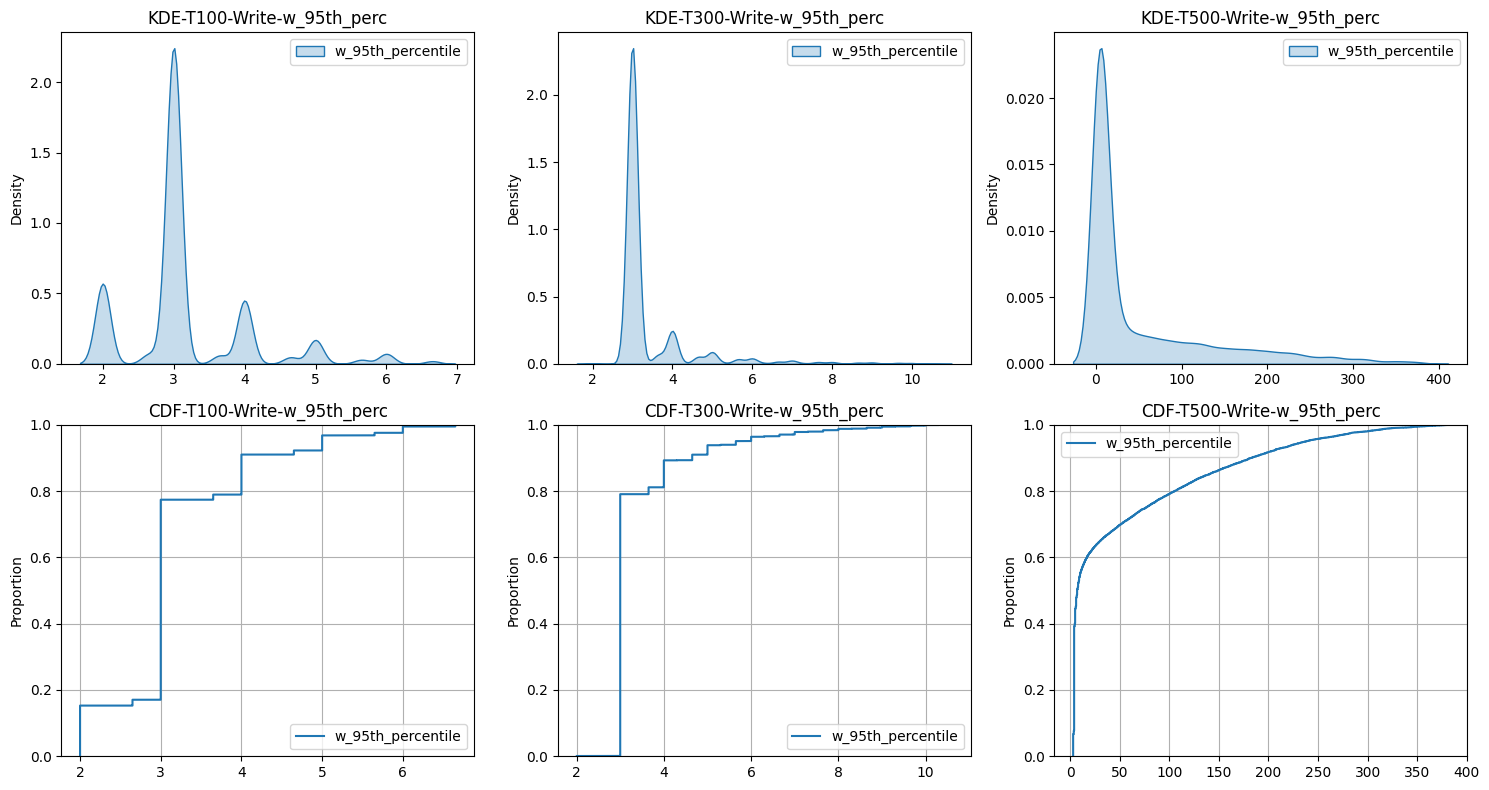

In [66]:
# concat x and y, filtering by 99 percentil on y and split to x and y again
x_t100_f, y_t100_f = preprocess_datasets(x_t100, y_t100, 'w_95th_percentile', percentil=98)
x_t300_f, y_t300_f = preprocess_datasets(x_t300, y_t300, 'w_95th_percentile', percentil=98)
x_t500_f, y_t500_f = preprocess_datasets(x_t500, y_t500, 'w_95th_percentile', percentil=98)

# w_95th_percentile - t100 x t300 x t500
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sns.kdeplot(y_t100_f,fill=True, ax=axes[0, 0])
axes[0, 0].set_title("KDE-T100-Write-w_95th_perc")

sns.kdeplot(y_t300_f,fill=True, ax=axes[0, 1])
axes[0, 1].set_title("KDE-T300-Write-w_95th_perc")

sns.kdeplot(y_t500_f,fill=True, ax=axes[0, 2])
axes[0, 2].set_title("KDE-T500-Write-w_95th_perc")

sns.ecdfplot(data=y_t100_f, ax=axes[1,0])
axes[1,0].set_title("CDF-T100-Write-w_95th_perc")
axes[1,0].grid(True)

sns.ecdfplot(data=y_t300_f, ax=axes[1,1])
axes[1,1].set_title("CDF-T300-Write-w_95th_perc")
axes[1,1].grid(True)

sns.ecdfplot(data=y_t500_f, ax=axes[1,2])
axes[1,2].set_title("CDF-T500-Write-w_95th_perc")
# axes[2].set_xlim(0.0, 50)
axes[1,2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

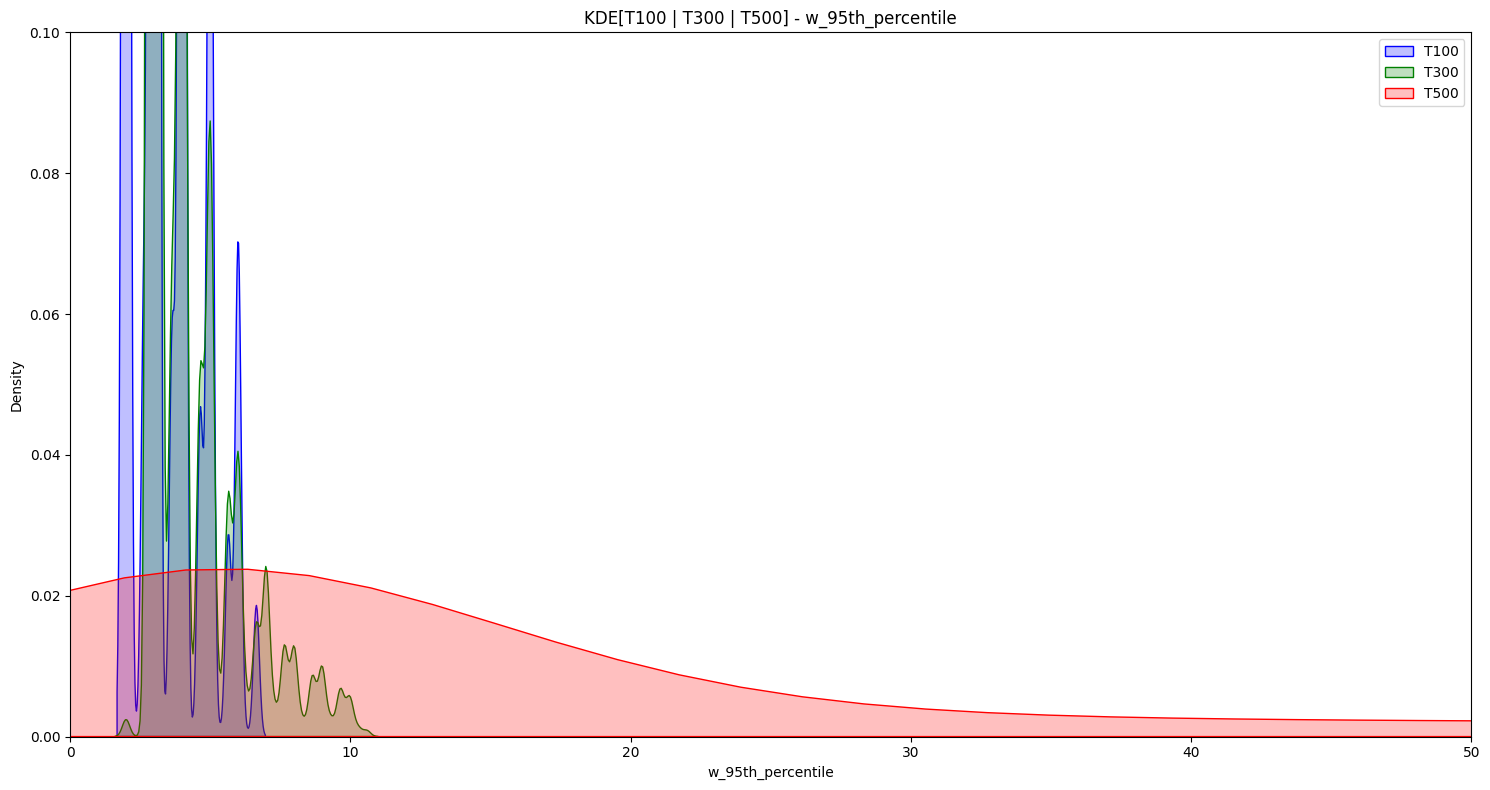

In [68]:
# w_95th_percentile - t100 x t300 x t500
# fig, axes = plt.subplots(1, 1, figsize=(15, 8))
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
sns.kdeplot(y_t100_f.squeeze(), color='blue', fill=True, label='T100')
sns.kdeplot(y_t300_f.squeeze(), color='green', fill=True, label='T300')
sns.kdeplot(y_t500_f.squeeze(), color='red', fill=True, label='T500')

axes.set_xlim(0.0, 50)
axes.set_ylim(0.0, 0.1)

plt.title(f"KDE[T100 | T300 | T500] - w_95th_percentile")
plt.legend()
plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

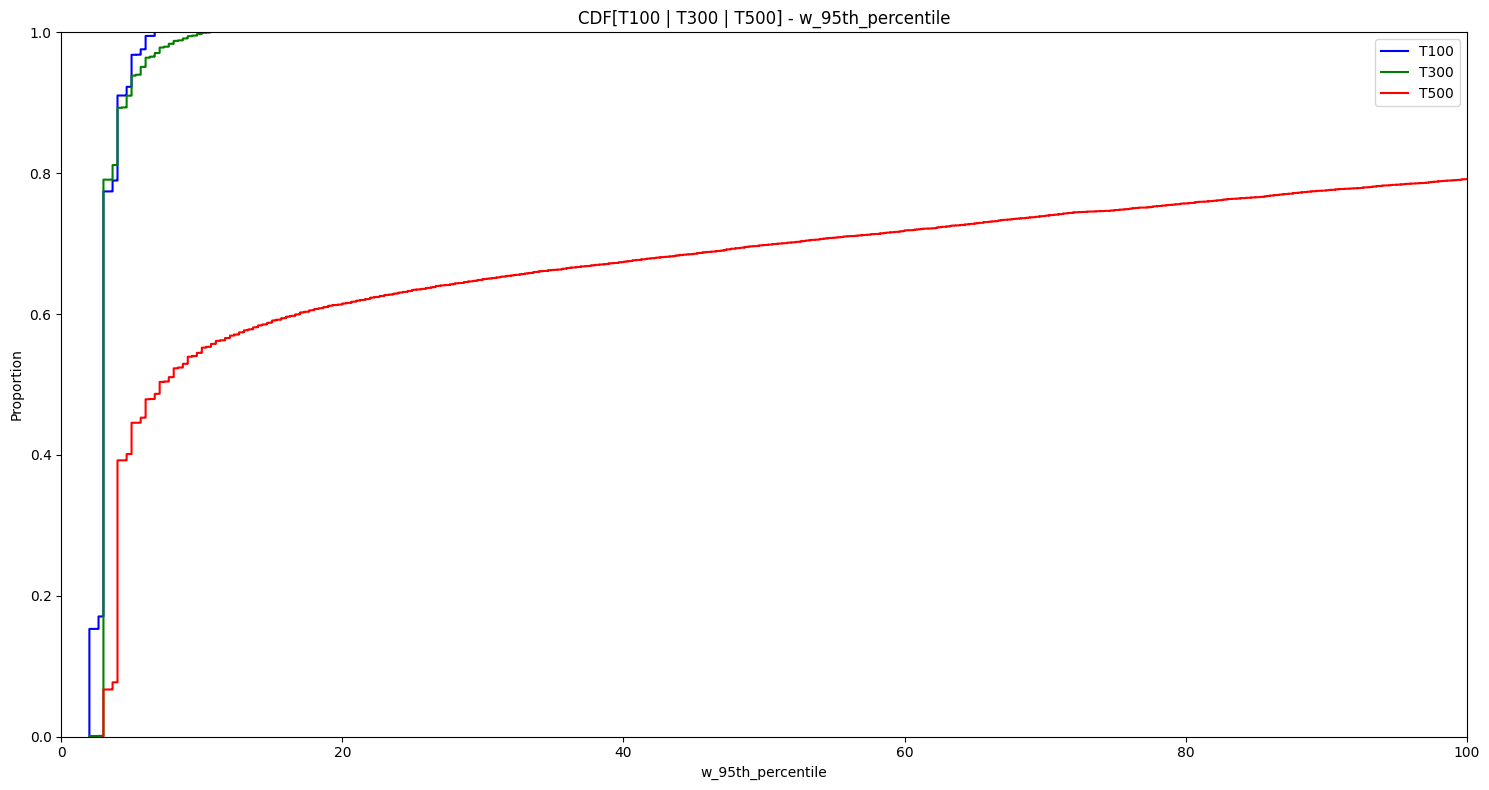

In [69]:
# w_95th_percentile - t100 x t300 x t500
# fig, axes = plt.subplots(1, 1, figsize=(15, 8))
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
sns.ecdfplot(y_t100_f.squeeze(), color='blue', label='T100')
sns.ecdfplot(y_t300_f.squeeze(), color='green', label='T300')
sns.ecdfplot(y_t500_f.squeeze(), color='red', label='T500')

axes.set_xlim(0.0, 100)

plt.title(f"CDF[T100 | T300 | T500] - w_95th_percentile")
plt.legend()
plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

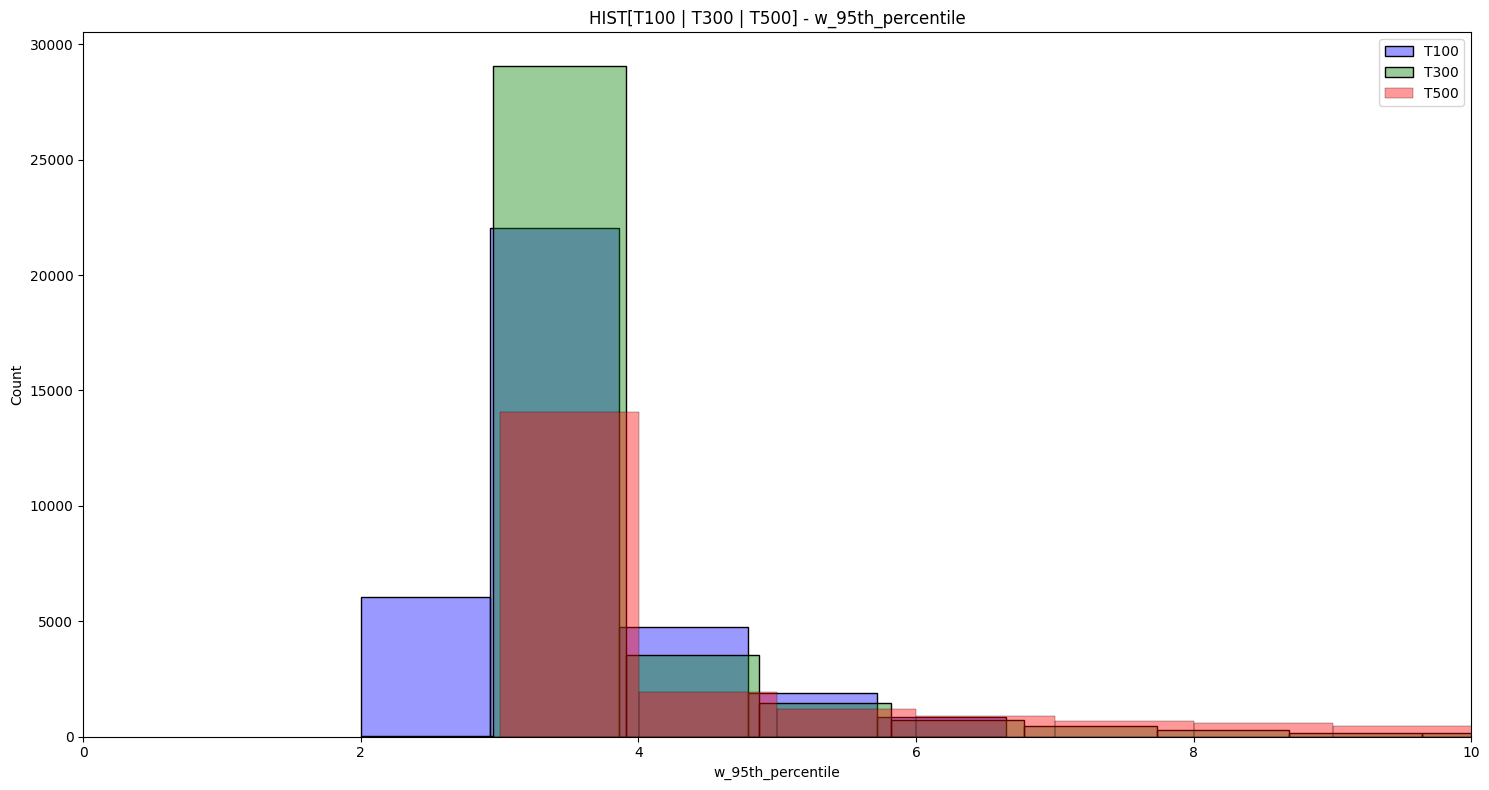

In [70]:
# w_95th_percentile - t100 x t300 x t500
# fig, axes = plt.subplots(1, 1, figsize=(15, 8))
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
sns.histplot(data=y_t100_f.squeeze(), color='blue', label='T100', binwidth=1, alpha=0.4)
sns.histplot(data=y_t300_f.squeeze(), color='green', label='T300', binwidth=1, alpha=0.4)
sns.histplot(data=y_t500_f.squeeze(), color='red', label='T500', binwidth=1, alpha=0.4)

axes.set_xlim(0.0, 10)

plt.title(f"HIST[T100 | T300 | T500] - w_95th_percentile")
plt.legend()
plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

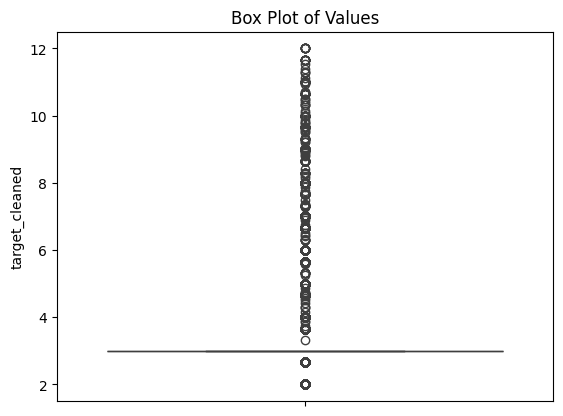

In [58]:
sns.boxplot(y_t100_f['target_cleaned'])
plt.title('Box Plot of Values')
plt.show()